# Numerical Bifurcation Analysis of Large Scale Systems: HW3

In the third homework we will have to compute non-trivial steady solutions of the Ginzburg-Landau equation,
$$ \partial_t u = \partial_{xx}u + \mu(u - u^3/3)\tag{GL1}$$
and from those solutions use natural continuation to compute the bifurcation diagram, for that branch.

## 1) Linking $\varepsilon$ and $\gamma$
The idea is to use the knowledge of the eigenfunctions, which are the solutions in the linear case, to determine nontrivial solutions to the Ginzburg-Landau equation, after a bifurcation. We "guess" that the true solutions are similar to the eigenfunctions, and use this guess in the Newton iteration scheme to determine the nontrivial solution. In the last part, we have found only the trivial solution. To prevent this from happening, we will look slightly past the bifurcation point, say that $\hat{\mu}_k = \mu_k ( 1 + \gamma) = k^2\pi^2 (1 + \gamma)$. We also have to adjust our eigenfunction, so we set $\hat{u}_k = \varepsilon u_k$. The first task is to find a relation between $\gamma$ and $\varepsilon$.

For this we are going to use a Galerkin projection. First we define $r(u) = u'' + \mu(u - u^3/3)$, then we project $r(\varepsilon u)$ onto the eigenvector and then integrate over the domain, that is:
\begin{align}
\int_0^1 \sin(\pi x) r(\varepsilon u)\mathrm{d}x &= \int_0^1 \sin(\pi x) r(\varepsilon \sin (\pi x))\mathrm{d}x \\
&= \int_0^1 \sin(\pi x) (-\pi^2 \varepsilon \sin (\pi x) + \pi^2(1+\gamma)(\varepsilon \sin (\pi x) - \varepsilon^3 \sin^3 (\pi x) / 3))\mathrm{d}x \\
&= -\pi^2 \varepsilon \int_0^1 \sin^2 (\pi x)\mathrm{d}x + \pi^2 \varepsilon (1 + \gamma)\left(\int_0^1 \sin^2 (\pi x)\mathrm{d}x - \dfrac{\varepsilon^2}{3}\int_0^1 \sin^4(\pi x)\right)\mathrm{d}x \\
&= \dfrac{\varepsilon}{2}\left(\gamma + \dfrac{\varepsilon^2}{4}\right) \\
&= 0
\end{align}
From this it follows that
$$\varepsilon  = 0 \quad \lor \quad \varepsilon = \pm 2 \sqrt{1 - \dfrac{1}{1+\gamma}}$$
So we have three solutions, since only one is positive, we take that one.

In [16]:
%matplotlib inline
from nbaolss import *
import numpy as np
import scipy
from scipy.linalg import eig
import matplotlib.pyplot as plt

## 2) Calculating non-trivial solution

Next, we want to find non-trivial solutions. For this we will pick a suitable starting point, for which we use the eigenvectors of the discretized linear problem. We then use Newton-Rhapson iterations to find a zero to our right hand side, which then hopefully will lead us a nontrivial solution.

In [17]:
# Sorts the eigenvalues. from the smallest in magnitude to the biggest
# Also rearranges the eigenvectors in the proper way
def sort(eig_val, eig_vec):
    # Calculate the new indices
    idx = np.argsort(np.abs(eig_val))
    
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:, idx]
    return eig_val, eig_vec

def epsilon(gamma):
    return 2 * np.sqrt(1 - 1 / (1 + gamma))

# Finds initial conditions on num_branches branches
def init(num_branches, size):
    gamma = 0.1
    eps = epsilon(gamma)
    
    eig_val, eig_vec = eig(-linGL1(size).A)
    eig_val, eig_vec = sort(eig_val, eig_vec)
    
    res = np.zeros((num_branches, size))
    mus = np.zeros((num_branches,))
    for idx in range(0, num_branches):
        uk = eps * eig_vec[:, idx] / np.max(eig_vec[:, idx])
        mus[idx] = np.real((1 + gamma) * eig_val[idx])
        res[idx, :] = zero_of_GL1(uk, size, mus[idx])
    return res, mus

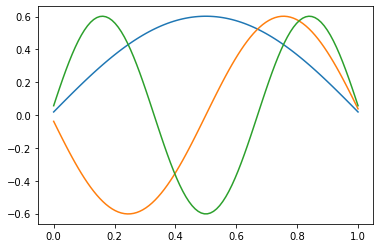

In [18]:
num_branches = 3
size = 100
res, mus = init(num_branches, size)

grid_pts = np.linspace(0, 1, size)
for idx in range(0, num_branches):
    plt.plot(grid_pts, res[idx, :])

## 3) Following the branch using natural continuation

Now we have found, for a certain parameter, a nontrivial solution. The next step is to following this solution as the parameter changes. This will gives us the bifurcation diagram, at least locally.

In [20]:
def cont(mu, u0, mu_end, steps):
    size = len(u0)
    mu_steps = np.linspace(mu, mu_end, steps)
    res = np.zeros((steps, size))
    res[0, :] = zero_of_GL1(u0, size, mu_steps[0])
    for step in range(1, steps):
        res[step, :] = zero_of_GL1(res[step - 1], size, mu_steps[step])
    return res
        

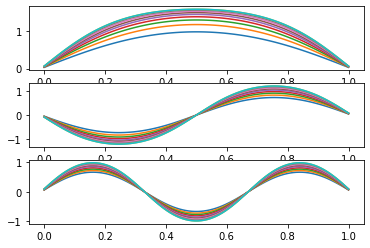

In [22]:
num_branches = 3
size = 100
grid_pts = np.linspace(0, 1, size)

us, mus = init(num_branches, size)
mus_end = mus + 20
steps = 10

fig, axs = plt.subplots(num_branches, 1)

for branch in range(0, num_branches):
    data = cont(mus[branch], us[branch, :], mus_end[branch], steps)
    for step in range(0, steps):
        axs[branch].plot(grid_pts, data[step])